In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [3]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "darkgrey",
    "family": "arial",
}

label_font = {
    "fontsize": 10,
    "family": "arial",
}

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
TRAIN_DATASET_PATH = 'datasets/course_project_train.csv'
TEST_DATASET_PATH = 'datasets/course_project_test.csv'
PREPARED_TRAIN_DATASET_PATH = 'datasets/course_project_train_prepared.csv'
PREPARED_TEST_DATASET_PATH = 'datasets/course_project_test_prepared.csv'

TRAIN_FULL_PATH = 'datasets/course_project_train_full.csv'
TRAIN_PART_PATH = 'datasets/course_project_train_part.csv'
VALID_PART_PATH = 'datasets/course_project_valid_part.csv'

SCALER_FILE_PATH = '../scaler.pkl'

#### Обзор обучающего датасета

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.shape

(7500, 17)

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Обзор тестового датасета

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.shape

df_test.head()

df_test.info()

df_test.isnull().sum()

### Обработка выбросов

**Обучающий датасет**

In [12]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*Maximum Open Credit*

In [13]:
median_open_credit = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [14]:
median_loan_ammount = df_train['Current Loan Amount'].median()
df_train.loc[df_train['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [15]:
df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] / 10

**Тестовый датасет**

df_test.describe()

*Maximum Open Credit*

df_test.loc[df_test['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

df_test.loc[df_test['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] = df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] / 10

### Обработка пропусков обучающего датасета

##### Annual Income

median_income = {}
for value in df_train['Years in current job'].unique():
    median_income[value] = df_train.loc[df_train['Years in current job'] == value, 'Annual Income'].median()
    
median_income

In [16]:
for i in df_train.index[df_train['Annual Income'].isnull()]:
    monthly_debt = df_train.iloc[i, 14]
    df_train.iat[i, 1] = df_train.loc[(df_train['Monthly Debt'] < monthly_debt * 1.2) & (df_train['Monthly Debt'] > monthly_debt * 0.8), 'Monthly Debt'].median()

for i in df_train.index[df_train['Annual Income'].isnull()]:
    years = df_train.iloc[i, 2]
    df_train.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
        & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

In [17]:
med_anual_income = df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

In [18]:
job_years = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

In [19]:
credit_score = {}
for value in df_train['Years of Credit History'].unique():
    credit_score[value] = df_train.loc[df_train['Years of Credit History'] == value, 'Credit Score'].median()

In [20]:
for i in df_train.index[df_train['Credit Score'].isnull()]:
    cred_history_years = df_train.iloc[i, 5]
    df_train.iat[i, 15] = credit_score[cred_history_years]

In [21]:
median_credit_score = df_train['Credit Score'].median()
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = median_credit_score

 for i in df_train.index[df_train['Credit Score'].isnull()]:
    home_ownership = df_train.iloc[i, 0]
    df_train.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
        & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

In [22]:
bankruptcies = {}
for value in df_train['Credit Score'].unique():
    bankruptcies[value] = df_train.loc[df_train['Credit Score'] == value, 'Bankruptcies'].median()

In [23]:
for i in df_train.index[df_train['Bankruptcies'].isnull()]:
    cred_score = df_train.iloc[i, 15]
    df_train.iat[i, 9] = bankruptcies[cred_score]

for i in df_train.index[df_train['Bankruptcies'].isnull()]:
    credit_score = df_train.iloc[i, 15]
    df_train.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
        & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

In [24]:
df_train = df_train.drop(columns='Months since last delinquent')

delinquent_months = {}
for value in df_train['Bankruptcies'].unique():
    delinquent_months[value] = df_train.loc[df_train['Bankruptcies'] == value, 'Months since last delinquent'].median()

delinquent_months

for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
    bankrupt = df_train.iloc[i, 9]
    df_train.iat[i, 8] = delinquent_months[bankrupt]

In [25]:
# for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
#     bankruptcies = df_train.iloc[i, 9]
#     df_train.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
#         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

In [26]:
df_train.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

### Обработка пропусков тестового датасета

##### Annual Income

for i in df_test.index[df_test['Annual Income'].isnull()]:
    years = df_test.iloc[i, 2]
    df_test.iat[i, 1] = median_income[years]

for i in df_test.index[df_test['Annual Income'].isnull()]:
    years = df_test.iloc[i, 2]
    df_test.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
        & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

for i in df_test.index[df_test['Credit Score'].isnull()]:
    home_ownership = df_test.iloc[i, 0]
    df_test.iat[i, 15] = credit_score[home_ownership]

for i in df_test.index[df_test['Credit Score'].isnull()]:
home_ownership = df_test.iloc[i, 0]
 df_test.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
       & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

for i in df_test.index[df_test['Bankruptcies'].isnull()]:
    cred_score = df_test.iloc[i, 15]
    df_test.iat[i, 9] = bankruptcies[cred_score]

for i in df_test.index[df_test['Bankruptcies'].isnull()]:
    credit_score = df_test.iloc[i, 15]
    df_test.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
        & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

df_test = df_test.drop(columns='Months since last delinquent')

for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
    bankrupt = df_test.iloc[i, 9]
    df_test.iat[i, 8] = delinquent_months[bankrupt]

 for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
     bankruptcies = df_test.iloc[i, 9]
     df_test.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

df_test.isnull().sum()

### Создаю дополнительные признаки

for purpose in df_train['Purpose'].unique():
    credit_default = df_train.loc[df_train['Purpose'] == purpose, 'Credit Default'].value_counts()
    print(credit_default, '\n\n')

df_train['Purpose'].unique()

### Корреляционная матрица

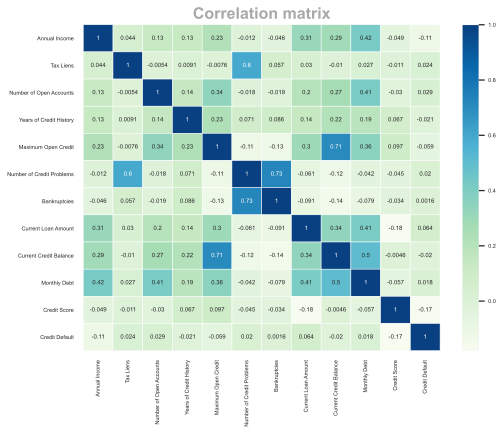

In [27]:
plt.figure(figsize = (8, 6))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontdict=title_font)

plt.show()

### Заменяю пробелы в наименованиях признаков на нижние подчеркивания

In [28]:
NEW_NAMES = {'Home Ownership': 'Home_ownership', 'Annual Income': 'Annual_income', 
             'Years in current job': 'Years_in_current_job', 'Tax Liens': 'Tax_liens', 
            'Number of Open Accounts': 'Number_of_open_accounts', 'Years of Credit History': 'Years_of_credit_history',
            'Maximum Open Credit': 'Maximum_open_credit', 'Number of Credit Problems': 'Number_of_credit_problems',
            'Current Loan Amount': 'Current_loan_amount', 'Current Credit Balance': 'Current_credit_balance',
            'Monthly Debt': 'Monthly_debt', 'Credit Score': 'Credit_score', 'Credit Default': 'Credit_default'}

In [29]:
df_train.rename(columns=NEW_NAMES, inplace=True)
df_train.head()

,Home_ownership,Annual_income,Years_in_current_job,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Purpose,Term,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Credit_default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Заменяю пробелы в наименованиях признаков на нижние подчеркивания

In [30]:
df_train.rename({'Years_in_current_job_10+ years': 'Years_in_current_job_10_years', 
                 'Years_in_current_job_< 1 year': 'Years_in_current_job_0_year'}, axis=1, inplace=True)
df_train.head()

,Home_ownership,Annual_income,Years_in_current_job,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Purpose,Term,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Credit_default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Обзор категориальных переменных

#### Обучающий датасет

In [31]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home_ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_ownership, dtype: int64
****************************************************************************************************

Years_in_current_job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [32]:
df_train['Term_binary'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [33]:
df_train['Home_ownership_digit'] = df_train['Home_ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

In [34]:
obj_columns = ['Years_in_current_job', 'Purpose']

In [35]:
train_dummies = pd.get_dummies(df_train[obj_columns])
df_train = pd.concat([df_train, train_dummies], axis=1)

In [36]:
df_train.head()

,Home_ownership,Annual_income,Years_in_current_job,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Purpose,Term,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Credit_default,Term_binary,Home_ownership_digit,Years_in_current_job_1 year,Years_in_current_job_10+ years,Years_in_current_job_2 years,Years_in_current_job_3 years,Years_in_current_job_4 years,Years_in_current_job_5 years,Years_in_current_job_6 years,Years_in_current_job_7 years,Years_in_current_job_8 years,Years_in_current_job_9 years,Years_in_current_job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df_train.shape

(7500, 44)

#### Тестовый датасет

for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

df_test['Term binary'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

df_test['Home Ownership digit'] = df_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

test_dummies = pd.get_dummies(df_test[obj_columns])
df_test = pd.concat([df_test, test_dummies], axis=1)

df_test['renewable_energy'] = 0

df_test.head()

df_test.info()

#### Сохраняю датасеты

In [38]:
df_train.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
#df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [39]:
DATASET_PATH = 'datasets/course_project_train.csv'
PREP_DATASET_PATH = 'datasets/course_project_train_prepared.csv'

In [40]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home_ownership,Annual_income,Years_in_current_job,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Purpose,Term,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Credit_default,Term_binary,Home_ownership_digit,Years_in_current_job_1 year,Years_in_current_job_10+ years,Years_in_current_job_2 years,Years_in_current_job_3 years,Years_in_current_job_4 years,Years_in_current_job_5 years,Years_in_current_job_6 years,Years_in_current_job_7 years,Years_in_current_job_8 years,Years_in_current_job_9 years,Years_in_current_job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [42]:
df_base.rename(columns=NEW_NAMES, inplace=True)
TARGET_NAME = 'Credit_default'
BASE_FEATURE_NAMES = df_base.columns.drop(['Months since last delinquent', 'Credit_default']).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

### Анализ целевой переменной

**Обзор распределения**

In [ ]:
df[TARGET_NAME].value_counts()

In [ ]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

In [ ]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

На основании этого графика, принял решение произвести оценку признаков с корреляцией более 0.05 по модулю.

**Оценка признака "Credit Score" в разрезе целевой переменной**

In [ ]:
credit_score_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Credit Score" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [ ]:
shapiro(credit_score_s)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [ ]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

In [ ]:
loan_amount_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
loan_amount_s = loan_amount_with_target_s['Current Loan Amount']
loan_amount_target_0 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 0]
loan_amount_target_1 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Current Loan Amount" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [ ]:
shapiro(loan_amount_s)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
loan_amount_s.hist()

plt.subplot(122)
probplot(loan_amount_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [ ]:
mannwhitneyu(loan_amount_target_0, loan_amount_target_1)

Согласно значению p-value, гипотеза о равности мат. ожиданий подтверждается.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют одинаковое распределение. 

**Оценка признака "Annual Income" в разрезе целевой переменной**

In [ ]:
annual_income_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Annual Income" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [ ]:
shapiro(annual_income_s)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [ ]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

График показывает, что интервалы имеют незначительное пересечение. Однако степеньиз взаимного пересечения менее установлененого в гипотизе уровня значимости, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Maximum Open Credit" в разрезе целевой переменной**

In [ ]:
max_credit_with_target_s = df[['Maximum Open Credit', TARGET_NAME]].sample(1000)
max_credit_s = max_credit_with_target_s['Maximum Open Credit']
max_credit_target_0 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 0]
max_credit_target_1 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(max_credit_target_0, shade=True, label='No default', color='g')
sns.kdeplot(max_credit_target_1, shade=True, label='Default', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Maximum Open Credit" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [ ]:
shapiro(max_credit_s)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Maximum Open Credit')
ax1.set_ylabel('Count')
ax1.set_title('Maximum Open Credit distribution')
max_credit_s.hist()

plt.subplot(122)
probplot(max_credit_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [ ]:
mannwhitneyu(max_credit_target_0, max_credit_target_1)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=max_credit_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

**Матрица корреляций**

In [ ]:
plt.figure(figsize = (12,8))

sns.set(font_scale=0.5)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [43]:
NUM_FEATURE_NAMES = ['Annual_income', 'Tax_liens', 'Number_of_open_accounts', 'Years_of_credit_history', 'Maximum_open_credit',
                     'Number_of_credit_problems', 'Bankruptcies', 'Current_loan_amount', 'Current_credit_balance', 
                     'Monthly_debt', 'Credit_score']

CAT_FEATURE_NAMES = ['Home_ownership', 'Years_in_current_job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [44]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home_ownership          category
Years_in_current_job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных

In [45]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()
df.head()

,Home_ownership,Annual_income,Years_in_current_job,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Purpose,Term,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Credit_default,Term_binary,Home_ownership_digit,Years_in_current_job_1 year,Years_in_current_job_10+ years,Years_in_current_job_2 years,Years_in_current_job_3 years,Years_in_current_job_4 years,Years_in_current_job_5 years,Years_in_current_job_6 years,Years_in_current_job_7 years,Years_in_current_job_8 years,Years_in_current_job_9 years,Years_in_current_job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,-0.650243,10+ years,-0.110953,-0.026674,1.133645,0.063194,1.664779,2.545732,debt consolidation,Short Term,0.002830,-0.762772,-0.872085,1.077391,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,-0.065942,10+ years,-0.110953,0.788223,-0.428528,0.798425,-0.340979,-0.337099,debt consolidation,Long Term,-0.257436,0.330781,0.004909,0.604398,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,-0.360646,8 years,-0.110953,-0.026674,2.369181,0.799469,-0.340979,-0.337099,debt consolidation,Short Term,0.002830,0.058379,-0.391034,0.801478,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,-0.302952,6 years,-0.110953,-0.637847,0.593985,-0.735496,1.664779,2.545732,debt consolidation,Short Term,-1.095166,-0.610282,-0.584980,-1.090493,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,-0.333924,8 years,-0.110953,0.380774,-0.669954,-0.381893,1.664779,-0.337099,debt consolidation,Short Term,-1.069235,-0.618292,-0.933631,-0.105091,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Сохранение модели для нормализации данных**

In [46]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и valid

In [92]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [93]:
X.rename({'Years_in_current_job_10+ years': 'Years_in_current_job_10_years', 
                 'Years_in_current_job_< 1 year': 'Years_in_current_job_0_year'}, axis=1, inplace=True)
X.head()

,Annual_income,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Term_binary,Home_ownership_digit,Years_in_current_job_1 year,Years_in_current_job_10_years,Years_in_current_job_2 years,Years_in_current_job_3 years,Years_in_current_job_4 years,Years_in_current_job_5 years,Years_in_current_job_6 years,Years_in_current_job_7 years,Years_in_current_job_8 years,Years_in_current_job_9 years,Years_in_current_job_0_year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-0.650243,-0.110953,-0.026674,1.133645,0.063194,1.664779,2.545732,0.002830,-0.762772,-0.872085,1.077391,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.065942,-0.110953,0.788223,-0.428528,0.798425,-0.340979,-0.337099,-0.257436,0.330781,0.004909,0.604398,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,-0.360646,-0.110953,-0.026674,2.369181,0.799469,-0.340979,-0.337099,0.002830,0.058379,-0.391034,0.801478,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,-0.302952,-0.110953,-0.637847,0.593985,-0.735496,1.664779,2.545732,-1.095166,-0.610282,-0.584980,-1.090493,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,-0.333924,-0.110953,0.380774,-0.669954,-0.381893,1.664779,-0.337099,-1.069235,-0.618292,-0.933631,-0.105091,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=27)

### Балансировка целевой переменной

In [95]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4042
1    3166
Name: Credit_default, dtype: int64

In [96]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и валидационного датасетов

In [60]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [61]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [62]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      3784
           1       0.61      0.46      0.53      2932

    accuracy                           0.64      6716
   macro avg       0.63      0.62      0.62      6716
weighted avg       0.63      0.64      0.63      6716

VALID

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1603
           1       0.44      0.43      0.44       647

    accuracy                           0.68      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit_default           
0               1245  358
1                366  281


**k ближайших соседей**

In [63]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3784
           1       0.74      0.67      0.71      2932

    accuracy                           0.76      6716
   macro avg       0.75      0.75      0.75      6716
weighted avg       0.76      0.76      0.75      6716

VALID

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1603
           1       0.35      0.38      0.37       647

    accuracy                           0.62      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.63      0.62      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit_default           
0               1141  462
1                398  249


**XGBoost**

In [55]:
X_train.head()

,Annual_income,Tax_liens,Number_of_open_accounts,Years_of_credit_history,Maximum_open_credit,Number_of_credit_problems,Bankruptcies,Current_loan_amount,Current_credit_balance,Monthly_debt,Credit_score,Term_binary,Home_ownership_digit,Years_in_current_job_1 year,Years_in_current_job_10+ years,Years_in_current_job_2 years,Years_in_current_job_3 years,Years_in_current_job_4 years,Years_in_current_job_5 years,Years_in_current_job_6 years,Years_in_current_job_7 years,Years_in_current_job_8 years,Years_in_current_job_9 years,Years_in_current_job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
1876,1.330310,-0.110953,1.399395,0.863815,4.842086,-0.340979,-0.337099,2.448946,1.392592,0.997617,1.037975,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4828,0.690645,-0.110953,0.584498,1.602297,2.074469,-0.340979,-0.337099,0.101224,2.816949,0.445796,0.643814,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6018,-1.158093,-0.110953,-0.434123,1.488684,-0.035827,-0.340979,-0.337099,2.645349,0.212005,-0.721908,0.170821,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6422,-0.030231,-0.110953,0.380774,1.644901,-0.677324,-0.340979,-0.337099,1.012123,-0.523965,-0.886926,0.446734,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1286,-0.365468,-0.110953,0.177050,-0.726760,-0.735953,-0.340979,-0.337099,-1.308385,-0.597729,-0.893718,0.210237,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
model_xgb = xgb.XGBClassifier(random_state=27)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3784
           1       0.98      0.98      0.98      2932

    accuracy                           0.98      6716
   macro avg       0.98      0.98      0.98      6716
weighted avg       0.98      0.98      0.98      6716

VALID

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1603
           1       0.43      0.37      0.40       647

    accuracy                           0.68      2250
   macro avg       0.60      0.59      0.59      2250
weighted avg       0.67      0.68      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit_default           
0               1287  316
1                406  241


**LightGBM**

In [65]:
model_lgbm = lgbm.LGBMClassifier(random_state=27)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3784
           1       0.91      0.91      0.91      2932

    accuracy                           0.92      6716
   macro avg       0.92      0.92      0.92      6716
weighted avg       0.92      0.92      0.92      6716

VALID

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1603
           1       0.44      0.43      0.44       647

    accuracy                           0.68      2250
   macro avg       0.61      0.60      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit_default           
0               1248  355
1                368  279


**CatBoost**

In [97]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=27)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4042
           1       0.88      0.88      0.88      3166

    accuracy                           0.89      7208
   macro avg       0.89      0.89      0.89      7208
weighted avg       0.89      0.89      0.89      7208

VALID

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1345
           1       0.44      0.44      0.44       530

    accuracy                           0.68      1875
   macro avg       0.61      0.61      0.61      1875
weighted avg       0.68      0.68      0.68      1875

CONFUSION MATRIX

col_0              0    1
Credit_default           
0               1051  294
1                297  233


### Выбор лучшей модели и подбор гиперпараметров

In [98]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 4], silent=True, random_state=27)

**Подбор гиперпараметров**

In [99]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7], 
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [100]:
cv=KFold(n_splits=5, random_state=27, shuffle=True)

In [101]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 2min 38s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000246495F79D0>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [102]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01}

In [103]:
rs.best_score_

0.515096012330111

### Обучение и оценка финальной модели

In [107]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=7, learning_rate=0.01, class_weights=[1, 3.5],
                                      silent=True, random_state=27)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.34      0.51      4042
           1       0.54      1.00      0.70      3166

    accuracy                           0.63      7208
   macro avg       0.77      0.67      0.60      7208
weighted avg       0.79      0.63      0.59      7208

VALID

              precision    recall  f1-score   support

           0       0.91      0.31      0.46      1345
           1       0.34      0.92      0.50       530

    accuracy                           0.48      1875
   macro avg       0.63      0.62      0.48      1875
weighted avg       0.75      0.48      0.47      1875

CONFUSION MATRIX

col_0             0    1
Credit_default          
0               414  931
1                40  490
Wall time: 7.6 s


### Перекрёстная проверка

f1-score

In [108]:
%%time

cv_score_f1 = cross_val_score(final_model, X, y, scoring=('f1'), cv=KFold(n_splits=10, shuffle=True, random_state=27))
cv_score_f1

Wall time: 1min 20s


array([0.51410658, 0.51010886, 0.54256854, 0.52160494, 0.48275862,
       0.51370851, 0.51908397, 0.53958944, 0.51282051, 0.49056604])

In [109]:
cv_score_f1.mean(), cv_score_f1.std()

(0.5146916025844411, 0.017583181495835258)

In [110]:
cv_score_f1.mean() - cv_score_f1.std(), cv_score_f1.mean() + cv_score_f1.std()

(0.49710842108860587, 0.5322747840802764)

Precision

In [111]:
%%time

cv_score_precision = cross_val_score(final_model, X, y, scoring=('precision'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score_precision

Wall time: 37 s


array([0.38668224, 0.38716814, 0.35806452, 0.3969555 , 0.35857461])

In [112]:
cv_score_precision.mean(), cv_score_precision.std()

(0.37748900289409526, 0.016076137416282037)

In [113]:
cv_score_precision.mean() - cv_score_precision.std(), cv_score_precision.mean() + cv_score_precision.std()

(0.3614128654778132, 0.3935651403103773)

Recall

In [114]:
%%time

cv_score_recall = cross_val_score(final_model, X, y, scoring=('recall'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score_recall

Wall time: 36.2 s


array([0.79186603, 0.81206497, 0.80048077, 0.75      , 0.81313131])

In [115]:
cv_score_recall.mean(), cv_score_recall.std()

(0.7935086152534864, 0.023124433044537276)

In [116]:
cv_score_recall.mean() - cv_score_recall.std(), cv_score_recall.mean() + cv_score_recall.std()

(0.7703841822089491, 0.8166330482980236)